# Izboljšave za Driver Inattention detector

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Cell output je bil odstranjen zaradi preglednosti.

In [3]:
train_images_path = '/kaggle/input/driver-inattention-detection-dataset/train'
annotation_file_path = '/kaggle/input/driver-inattention-detection-dataset/train/_annotations.txt'

class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

annotations = {}

with open(annotation_file_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        
        if len(parts) < 2:
            print(f'skipping due to the incorrect format: {line}')
            continue
            
        image_name = parts[0]
        
        bbox_and_class = parts[1].split(',')
        
        if len(bbox_and_class) <5:
            print(f"Skipping the line due to missing bouding box or class info: {line}")
            continue
            
        class_id = int(bbox_and_class[-1])
        
        annotations[image_name] = class_id

skipping due to the incorrect format: gA_4_s2_ir_face_mp4-440_jpg.rf.f0ab9d03d718ac287cac6fca394783d0.jpg

skipping due to the incorrect format: gA_4_s2_ir_face_mp4-440_jpg.rf.fa7c39ef44d869bdab6c298c89442f19.jpg

skipping due to the incorrect format: gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-401_jpg.rf.4a274f58e714facd11a3693a3325c3d5.jpg

skipping due to the incorrect format: gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-401_jpg.rf.c507475339c83c2de42f2400987923d2.jpg



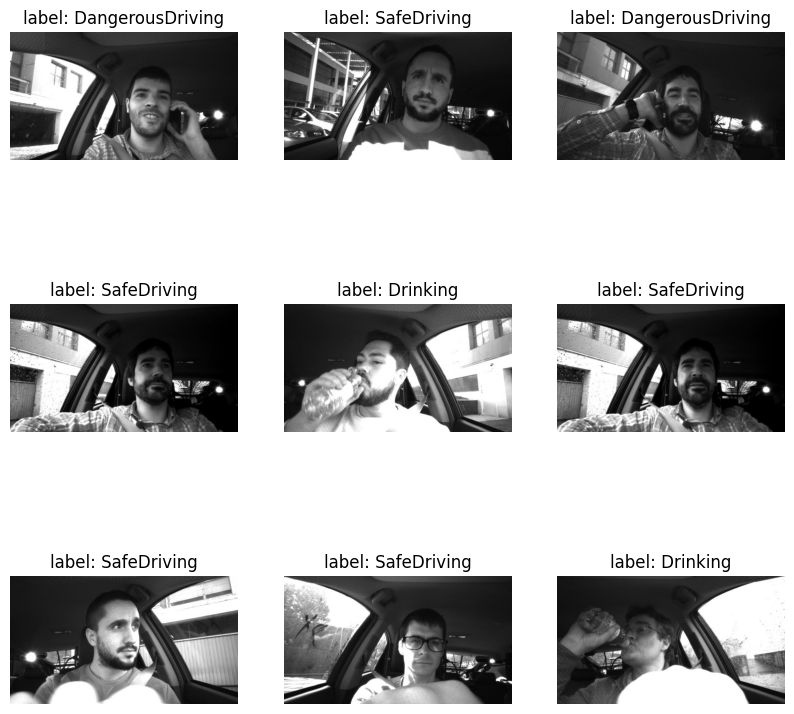

In [4]:
def load_image_and_label(image_name):
    
    img_path = os.path.join(train_images_path, image_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if image_name in annotations:
        class_id = annotations[image_name]
        return img, class_names[class_id]
    else:
        print(f'Warning: No label found for {image_name}')
        return img, "No label"
    
plt.figure(figsize = (10,10))
image_files = os.listdir(train_images_path)[:9]

for i, image_file in enumerate(image_files):
    img, label = load_image_and_label(image_file)

    ax = plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f'label: {label}')
    plt.axis('off')

plt.show()

## Preprocessing

In [5]:
def read_annotations(file_path):
    annotations = []
    with open(file_path,'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int,parts[1].split(',')))
                if len(bbox) !=5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(annotations,columns = ['image_name','x_min','y_min','x_max','y_max','class_id'])

In [6]:
target_size = (128,128)
def preprocess_image(image_path,target_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,target_size)
    return image  

In [7]:
def one_hot_encode_labels(labels,num_classes):
    encoder = OneHotEncoder(sparse = False)
    labels = np.array(labels).reshape(-1,1)
    one_hot_labels = encoder.fit_transform(labels)
    return one_hot_labels

In [8]:
train_folder = '/kaggle/input/driver-inattention-detection-dataset/train'
test_folder = '/kaggle/input/driver-inattention-detection-dataset/test'
valid_folder = '/kaggle/input/driver-inattention-detection-dataset/valid'

train_annotations = read_annotations('/kaggle/input/driver-inattention-detection-dataset/train/_annotations.txt')
test_annotations = read_annotations('/kaggle/input/driver-inattention-detection-dataset/test/_annotations.txt')
valid_annotations = read_annotations('/kaggle/input/driver-inattention-detection-dataset/valid/_annotations.txt')

In [9]:
def preprocess_dataset(annotations,folder_path,num_classes):
    images = []
    labels = []
    
    for _, row in annotations.iterrows():
        image_path = os.path.join(folder_path,row['image_name'])
        image = preprocess_image(image_path,target_size)
        images.append(image)
        labels.append(row['class_id'])
    images = np.array(images)
    one_hot_labels = one_hot_encode_labels(labels, num_classes)
    return images,one_hot_labels

num_classes = 6

train_images, train_labels = preprocess_dataset(train_annotations,train_folder,num_classes)
test_images, test_labels = preprocess_dataset(test_annotations,test_folder,num_classes)
valid_images, valid_labels = preprocess_dataset(valid_annotations,valid_folder,num_classes)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Stanje dataseta po preprocesiranju

In [10]:
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')
print(f'Valid images shape: {valid_images.shape}')
print(f'Valid labels shape: {valid_labels.shape}')

Train images shape: (11948, 128, 128, 3)
Train labels shape: (11948, 6)
Test images shape: (985, 128, 128, 3)
Test labels shape: (985, 6)
Valid images shape: (1922, 128, 128, 3)
Valid labels shape: (1922, 6)


### Kreacija učne in validacijske množice

In [11]:
(X_train, y_train), (X_val, y_val) = (train_images, train_labels), (valid_images, valid_labels)

### Poskus izboljšave na področju podatkov
**Za boljše učenje sem nad podatki izvedel normalizacijo in augmentacijo s pomočjo tensorflowa.**

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Rotate images up to 20 degrees
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shearing
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill missing pixels after transformations
)


In [18]:
train_generator = datagen.flow(
    X_train,  # Training images
    y_train,  # Corresponding labels
    batch_size=32  # Batch size
)

## Nevronska mreža (CNN)

### Dodaten Batch Normalization
S tem sem dosegel:
* Normalizacijo izhoda vsakega layer-ja

In [21]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,112,518 (19.50 MB)

 Trainable params: 5,111,558 (19.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [22]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Učenje na augmentiranih podatkih

In [ ]:
history = model.fit(
    train_generator,  # Augmented data generator
    validation_data=(X_val, y_val),
    epochs=15
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.3913 - loss: 2.9486 - val_accuracy: 0.0650 - val_loss: 605.2191
Epoch 2/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - accuracy: 0.5106 - loss: 1.3110 - val_accuracy: 0.4136 - val_loss: 1345.3890
Epoch 3/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.5746 - loss: 1.1462 - val_accuracy: 0.4017 - val_loss: 803.2566
Epoch 4/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.6404 - loss: 0.9890 - val_accuracy: 0.4188 - val_loss: 578.1329
Epoch 5/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.6624 - loss: 0.9077 - val_accuracy: 0.3907 - val_loss: 309.3617
Epoch 6/15
  5/374 ━━━━━━━━━━━━━━━━━━━━ 7:09 1s/step - accuracy: 0.7365 - loss: 0.7257

KeyboardInterrupt: 

**Model z dodanim batch normalization-om se na augmentiranih podatkih ni dobro učil, zato sem treniranje modela prekinil.**

### Učenje na prvotnih podatkih

In [24]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.7369 - loss: 0.6936 - val_accuracy: 0.7596 - val_loss: 0.6763
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.8013 - loss: 0.5339 - val_accuracy: 0.8158 - val_loss: 0.5113
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.8395 - loss: 0.4511 - val_accuracy: 0.8897 - val_loss: 0.3308
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.8636 - loss: 0.3601 - val_accuracy: 0.8835 - val_loss: 0.3048
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - accuracy: 0.8888 - loss: 0.3145 - val_accuracy: 0.6535 - val_loss: 1.0802
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - accuracy: 0.9068 - loss: 0.2732 - val_accuracy: 0.8725 - val_loss: 0.4168
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.9141 - loss: 0.2418 - val_accuracy: 0.8730 - val_loss: 0.4462
Epoch 8/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - accuracy: 0.9274 - loss: 0.2015 - val_accu

KeyboardInterrupt: 

**Učenje modela sem prekinil, po 12. epochu, saj ni bila vidna konvergenca (accuracy na validacijski množici je vseboval nihanja), dosegel pa sem višjo natančnost kot pri začetnem modelu. Pravtako je razvidno, da se model bolje uči na prvotnih neaugmentiranih podatkih.**

**Vizualizacija kako model napove labele za naključnih 12 slik. Tudi z napačno odločitvijo v tem primeru sem zadovoljen, saj voznik, kljub labeli "SafeDriving" izgleda zaspan kar je opazil tudi model.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


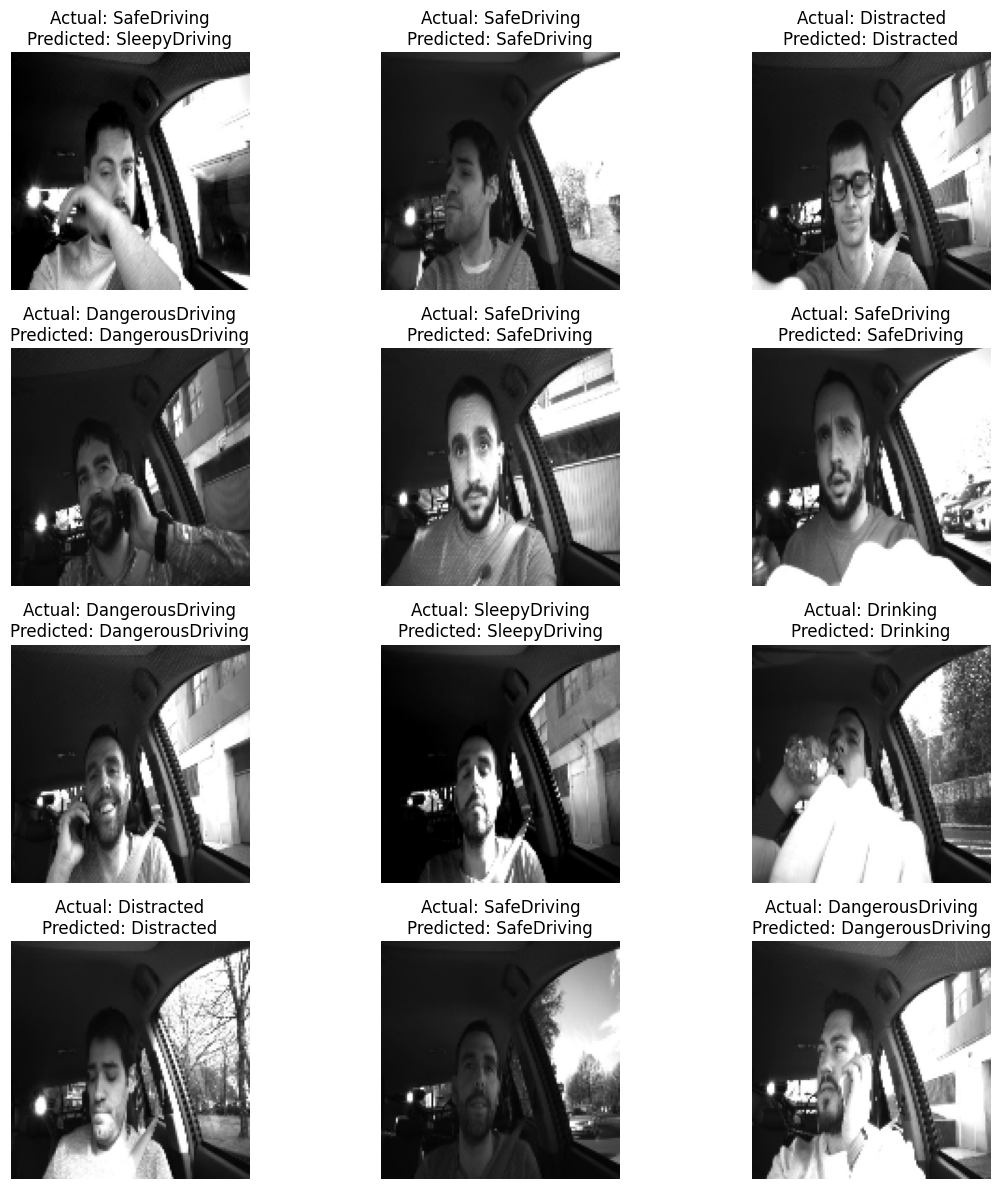

In [27]:
def plot_images_grid_with_predictions(images, actual_labels, predicted_labels, class_names, grid_size=(4, 3)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            actual_label = class_names[np.argmax(actual_labels[i])]
            predicted_label = class_names[np.argmax(predicted_labels[i])]
            ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

class_names = ['DangerousDriving', 'Distracted', 'Drinking', 'SafeDriving', 'SleepyDriving', 'Yawn']

# Select 12 random test images
indices = np.random.choice(len(test_images), 12, replace=False)
sample_images = test_images[indices]
sample_actual_labels = test_labels[indices]

# Predict the labels
sample_predicted_labels = model.predict(sample_images)

# Plot the images in a grid with predictions
plot_images_grid_with_predictions(sample_images, sample_actual_labels, sample_predicted_labels, class_names)

### Končna natančnost modela na testni množici

In [26]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
test_accuracy = test_accuracy * 100
print(f'Test accuracy: {test_accuracy:.2f}%')

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.9516 - loss: 0.2136
Test accuracy: 94.82%


### Analiza
**S tem pristopom sem dosegel največjo natančnost nad testno množico (94,8%) in za 5% izboljšal začetni model. Glede na to, da ima output 6 razredov je ta natančnost dobra.**

#### Shranjevanje modela

In [28]:
# Save the entire model
model.save("batch_norm_model.keras")

In [29]:
model.save('batch_norm_model.h5')

## Global average pooling
**Zamenjal sem Flatten layer z GlobalAveragePooling2D(), na tak način zmanjšal število učnih parametrov, in se izognil overfittingu.**

In [30]:
from tensorflow.keras.layers import GlobalAveragePooling2D

model_global_pooling = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])


In [32]:
model_global_pooling.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_2 = model_global_pooling.fit(X_train, y_train, epochs=14, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/14
374/374 ━━━━━━━━━━━━━━━━━━━━ 233s 617ms/step - accuracy: 0.4557 - loss: 2.5935 - val_accuracy: 0.6753 - val_loss: 0.8502
Epoch 2/14
374/374 ━━━━━━━━━━━━━━━━━━━━ 230s 614ms/step - accuracy: 0.6944 - loss: 0.8366 - val_accuracy: 0.7711 - val_loss: 0.6400
Epoch 3/14
374/374 ━━━━━━━━━━━━━━━━━━━━ 241s 644ms/step - accuracy: 0.7809 - loss: 0.5969 - val_accuracy: 0.8335 - val_loss: 0.4975
Epoch 4/14
374/374 ━━━━━━━━━━━━━━━━━━━━ 231s 619ms/step - accuracy: 0.8273 - loss: 0.4769 - val_accuracy: 0.8413 - val_loss: 0.4663
Epoch 5/14
374/374 ━━━━━━━━━━━━━━━━━━━━ 265s 628ms/step - accuracy: 0.8570 - loss: 0.3907 - val_accuracy: 0.8626 - val_loss: 0.4335
Epoch 6/14
374/374 ━━━━━━━━━━━━━━━━━━━━ 242s 647ms/step - accuracy: 0.8835 - loss: 0.3347 - val_accuracy: 0.8455 - val_loss: 0.4243
Epoch 7/14
374/374 ━━━━━━━━━━━━━━━━━━━━ 230s 615ms/step - accuracy: 0.8990 - loss: 0.2730 - val_accuracy: 0.8850 - val_loss: 0.3661
Epoch 8/14
374/374 ━━━━━━━━━━━━━━━━━━━━ 232s 621ms/step - accuracy: 0.9174 -

**Učenje modela se je nepričakovano ustavilo pri 14. epochu, zato sem model shranil, ponovno naložil in recompile-al model, ter učenje izvedel še nad dodatnima dvema epochoma.**

In [34]:
#Natančnost po 13. epochu
test_loss, test_accuracy = model_global_pooling.evaluate(test_images, test_labels)
test_accuracy = test_accuracy * 100
print(f'Test accuracy: {test_accuracy:.2f}%')

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.8981 - loss: 0.3901
Test accuracy: 89.24%


In [35]:
#Shranjevanje modela
model_global_pooling.save('model_checkpoint.h5')

In [36]:
#Reload
from tensorflow.keras.models import load_model

model_global_pooling = load_model('model_checkpoint.h5')

In [39]:
#Recompiling
from tensorflow.keras.optimizers import Adam

model_global_pooling.compile(optimizer=Adam(learning_rate=0.001), 
                             loss='categorical_crossentropy', 
                             metrics=['accuracy'])

In [40]:
history_resume = model_global_pooling.fit(X_train, y_train, 
                                          epochs=15,  # Specify new total epochs (e.g., 20)
                                          initial_epoch=13,  # Resume from the 13th epoch
                                          batch_size=32, 
                                          validation_data=(X_val, y_val))


Epoch 14/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 264s 701ms/step - accuracy: 0.9572 - loss: 0.1223 - val_accuracy: 0.9173 - val_loss: 0.4136
Epoch 15/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 260s 695ms/step - accuracy: 0.9675 - loss: 0.0922 - val_accuracy: 0.9121 - val_loss: 0.3578


### Končna natančnost modela

In [41]:
#Natančnost po 15. epochu
test_loss, test_accuracy = model_global_pooling.evaluate(test_images, test_labels)
test_accuracy = test_accuracy * 100
print(f'Test accuracy: {test_accuracy:.2f}%')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.9124 - loss: 0.3357
Test accuracy: 91.07%


#### Shranjevanje modela

In [43]:
model.save("global_pooling_model.keras")

In [42]:
model.save('global_pooling_model.h5')

### Analiza
**Uspelo mi je doseči natančnost 91%, z dodatnimi epochi, bi jo verjetno lahko še povečal, a sem bil dokaj omejen s strani strojne opreme. Tudi ta rezultat je boljši od začetnega modela.**

## Končne ugotovitve
* Model bi se dalo izboljšati s še več raznolikimi podatki (slikami)
* Na slikah ni žensk, ali drugih ras, kar bi lahko povzročalo probleme
* Na slikah so vsi vozniki na isti strani, kar bi lahko povzročalo probleme v državah, kjer vozijo po levi strani